# Adaptive ESI for 2.5D Spatial Data

**2.5D interpolation** refers to spatial estimation on **curved surfaces** in 3D space. Each (X, Y) location has exactly one Z coordinate (e.g., elevation), forming a surface rather than a volume.

| Aspect | 2D (Flat) | 2.5D (Surface) | 3D (Volume) |
|--------|-----------|----------------|-------------|
| **Geometry** | Flat plane | Curved surface | Full volume |
| **Coordinates** | (X, Y) | (X, Y, Z) | (X, Y, Z) |
| **Example** | Flat map | Terrain | Underground layers |

Common applications include:

- **Terrain-based interpolation**: Temperature, precipitation on hillslopes
- **Watershed analysis**: Stream chemistry varying with elevation

The non-gridded implementation of ESI provides the necessary flexibility for 2.5D interpolation, as it is not possible to represent a curved surface with a common gridded approach.

**Adaptive ESI** extends the standard ESI framework by making local interpolators adaptive to each partition cell's specific conditions. Instead of using fixed parameters globally, Adaptive ESI optimizes IDW parameters for each partition cell independently using leave-one-out (LOO) validation with mean absolute error (MAE) or mean squared error (MSE) minimization. This enables the method to:

- Capture local anisotropies and spatial continuities
- Handle non-stationary spatial processes
- Require no manual variogram modeling or stationarity assumptions
- Provide uncertainty estimates via ensemble variance


## Setup

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from pathlib import Path

# Add parent directory
sys.path.append(str(Path.cwd().parent))

# Import utilities and spatialize
from utils import PrecipitationCaseStudy
from spatialize.gs.esi import esi_nongriddata
import spatialize.gs.esi.lossfunction as lf

import seaborn as sns
sns.set_theme(context='notebook', style='whitegrid')

## Loading Real 2.5D Data

We'll use the Maipo Basin precipitation dataset, which demonstrates a real 2.5D interpolation scenario where precipitation varies with both geographic location (X, Y) and elevation (Z).

In [2]:
# Load case study
case_study = PrecipitationCaseStudy()

# Get ESI inputs
points, values, xi = case_study.model_inputs()

### Visualizing the Input Data

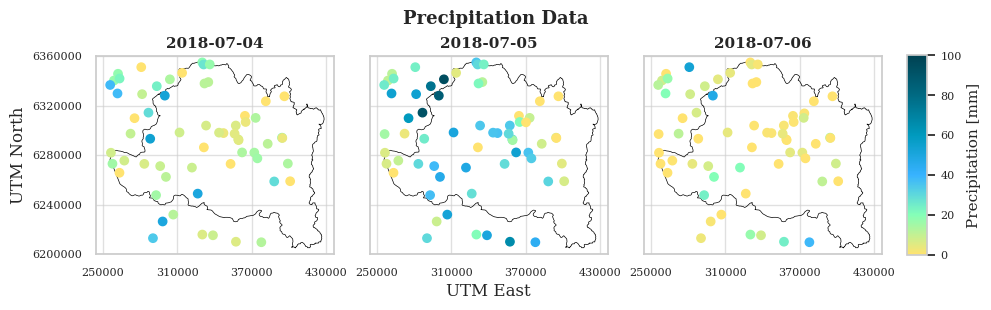

In [3]:
fig, axs = case_study.plot_input_data()
plt.show()

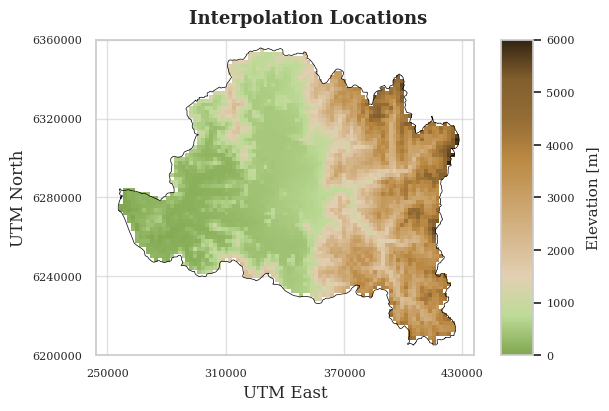

In [4]:
fig, ax = case_study.plot_interpolation_locations()
plt.show()

## Running ESI for 2.5D Data


For 2.5D surfaces, we use `esi_nongriddata()` with 3D coordinates (X, Y, Z) where each point represents a location on the curved surface.

### Adaptive ESI 

In [5]:
print("Running Adaptive ESI for 2.5D surface data...")

# To store results
adaptive_esi_results = case_study.locs.copy()
adaptive_esi_results.columns = pd.MultiIndex.from_tuples([(x, '') for x in adaptive_esi_results.columns])

for date in case_study.dates:
    # Loss function: Operational error for the observed dynamic range
    op_error = lf.OperationalErrorLoss(np.abs(np.nanmin(values[date]) - np.nanmax(values[date])))

    # Using Adaptive ESI
    result_adaptive = esi_nongriddata(
        points=points[date],
        values=values[date],
        xi=xi,
        local_interpolator="adaptiveidw",
        parallelize=True,
        metric='mse',
        p_process="mondrian",
        n_partitions=300,
        alpha=0.8,
        seed=1500
    )

    # Store results
    adaptive_esi_results[(date, 'value')] = result_adaptive.estimation()
    adaptive_esi_results[(date, 'precision')] = result_adaptive.precision(op_error)

Running Adaptive ESI for 2.5D surface data...
finished 100% of 300 iterations ... 

done (elapsed time:  9s)
finished 100% of 300 iterations ... 

done (elapsed time:  1s)
finished 100% of 300 iterations ... 

done (elapsed time:  7s)
finished 100% of 300 iterations ... 

done (elapsed time:  1s)
finished 100% of 300 iterations ... 

done (elapsed time:  7s)
finished 100% of 300 iterations ... 

done (elapsed time:  1s)


### Fixed ESI

For comparison, we run ESI with standard IDW. Unlike Adaptive ESI, Fixed ESI uses the same interpolation parameters across all partition cells.

In [6]:
print("Running Fixed ESI with exponent=2.0...")

# To store results
fixed_esi_results = case_study.locs.copy()
fixed_esi_results.columns = pd.MultiIndex.from_tuples([(x, '') for x in fixed_esi_results.columns])

for date in case_study.dates:
    # Loss function: Operational error for the observed dynamic range
    op_error = lf.OperationalErrorLoss(np.abs(np.nanmin(values[date]) - np.nanmax(values[date])))

    # Using Fixed ESI
    result_fixed = esi_nongriddata(
        points=points[date],
        values=values[date],
        xi=xi,
        local_interpolator="idw",
        exponent=2.0,
        p_process="mondrian",
        n_partitions=300,
        alpha=0.8,
        seed=1500
    )

    # Store results
    fixed_esi_results[(date, 'value')] = result_fixed.estimation()
    fixed_esi_results[(date, 'precision')] = result_fixed.precision(op_error)

Running Fixed ESI with exponent=2.0...
finished 100% of 300 iterations ... 

done (elapsed time:  1s)
finished 100% of 300 iterations ... 

done (elapsed time:  1s)
finished 100% of 300 iterations ... 

done (elapsed time:  1s)


## Visualizing Results

The precipitation case study includes a built in function that automatically plots the results for all three dates.

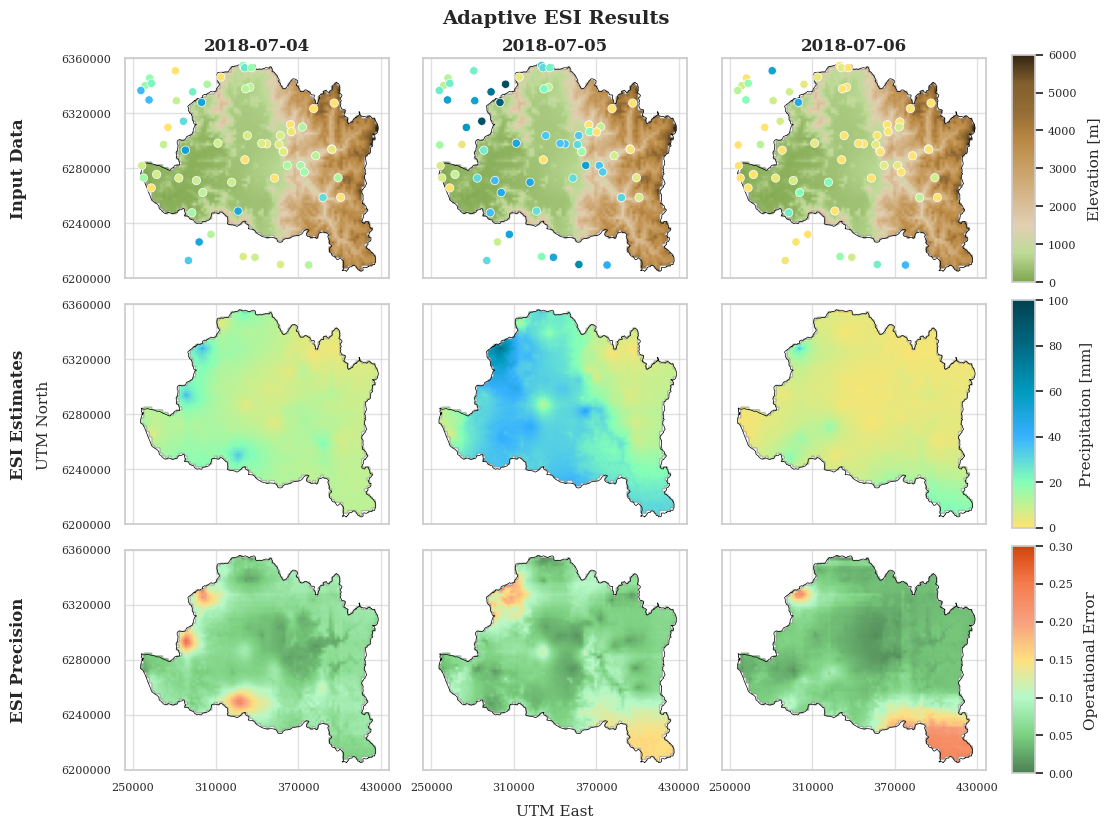

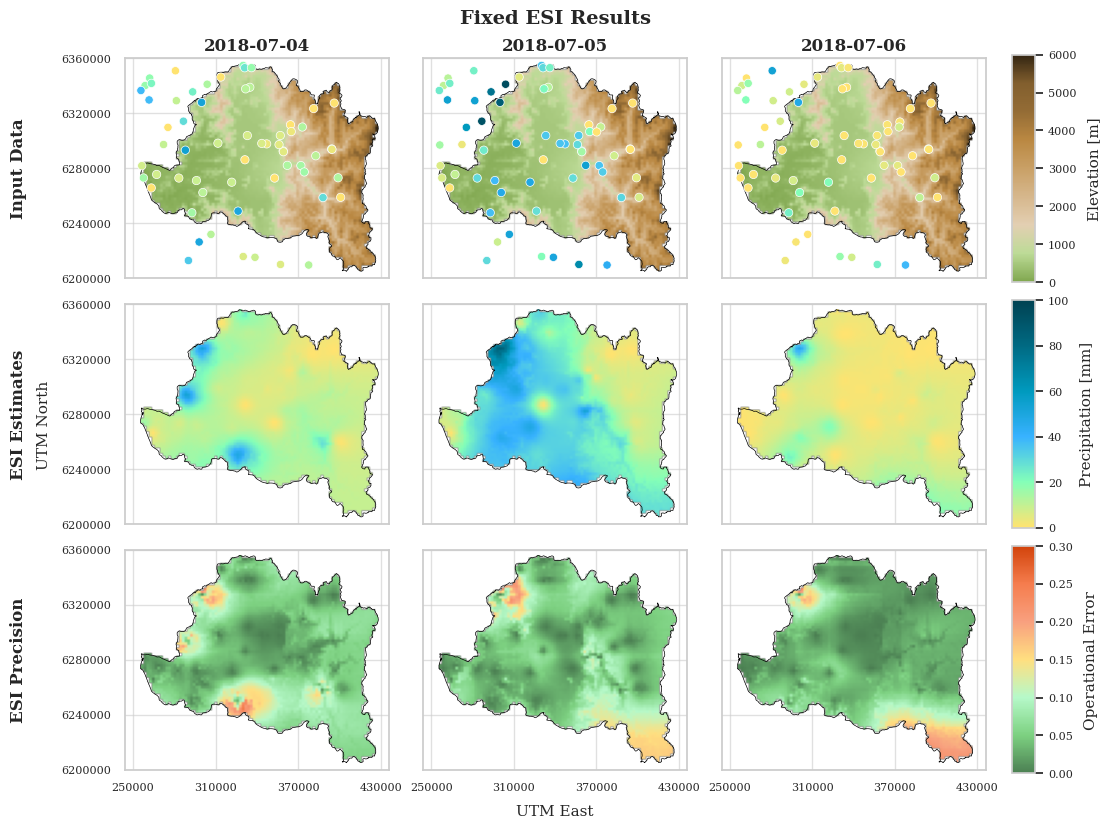

In [7]:
# Adaptive ESI
case_study.plot_esi_results(adaptive_esi_results, precision_function='Operational Error', fig_title='Adaptive ESI Results')
plt.show()

# Fixed ESI
case_study.plot_esi_results(fixed_esi_results, precision_function='Operational Error', fig_title='Fixed ESI Results')
plt.show()

In this case, both ESI implementations produce similar estimates. The most notable difference is how each model handles outliers: Adaptive ESI isolates these values to a smaller area of influence when compared with fixed ESI. Additionally, Adative ESI shows overall higher uncertainty, which might be reasonable on a scarce data scenario like this one.

## References

> Egaña, Á.F., Valenzuela, M.J., Maleki, M. et al. *Adaptive ensemble spatial analysis*.
> Scientific Reports **15**, 26599 (2025).
> https://doi.org/10.1038/s41598-025-08844-z